# TF-TRT Keras Classification Examples:

##### In this notebook, we cover a variety of classification base networks pulled from the tensorflow.keras.applications project!
##### This demonstrates TF-TRT working on a variety of model architectures out of the box. This is a great way to demonstrate the ease of use of TF-TRT. TF-TRT can still optimize parts of your network even if it contains layers that are not supported by TensorRT itself. This makes it easy to get a first-pass at an optimized model as we will demonstrate here.

#### 1. TensorflowRT Introduction
![TensorRTIntroduction](img/TensorRTIntroduction.jpg)

#### 2. TensorflowRT Framework
![TensorRTFramework](img/TensorRTFramework.jpg)

#### 3. TensorflowRT Optimization
![TensorRTOptimizer](img/TensorRTOptimizer.jpg)

#### 4. TensorflowRT Graph Optimization
![TensorRTGraph](img/TensorRTGraph.jpg)


Let's make sure our GPUs are properly configured and visible:

#### Remember to sucessfully deploy a TensorRT model, you have to make __five key decisions__:

### 1. __What format should I save my model in?__
### 2. __What batch size(s) am I running inference at?__
### 3. __What precision am I running inference at?__
### 4. __What TensorRT path am I using to convert my model?__
### 5. __What runtime am I targeting?__

#### Let's get to it!

## 1. What format should I save my model in?

TF-TRT requires SavedModel format in Tensorflow 2.x:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 

### LAB 9-2 : 합성곱 신경망으로 패션 MNIST 분류를 개선하기

In [2]:
# tensorflow와 tf.keras를 임포트한다
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# 패션 MNIST 데이터는 keras의 데이터셋에 있으며, 이를 학습용, 테스트 데이터로 구분하자
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
print(train_images.shape)  # 학습 이미지의 형태와 레이블을 출력한다
print(train_labels)
print(test_images.shape)

(60000, 28, 28)
[9 0 0 ... 3 0 5]
(10000, 28, 28)


In [4]:
train_images = train_images[:, :, :, np.newaxis]
test_images = test_images[:, :, :, np.newaxis]

In [5]:
model = keras.models.Sequential( [
    keras.layers.Conv2D(input_shape = (28, 28, 1),
                        kernel_size = (3,3), padding = 'same', 
                        filters = 32),
     keras.layers.MaxPooling2D((2, 2), strides=2),
     keras.layers.Conv2D(kernel_size = (3,3), padding ='same', 
                        filters = 64),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(kernel_size = (3,3), padding = 'same', 
                        filters = 32),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax'),
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [7]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
                    epochs=5, validation_split=0.25)

Epoch 1/5
1407/1407 [==============================] - 30s 14ms/step - loss: 0.9899 - accuracy: 0.6676 - val_loss: 0.4649 - val_accuracy: 0.8331
Epoch 2/5
1407/1407 [==============================] - 19s 13ms/step - loss: 0.3878 - accuracy: 0.8616 - val_loss: 0.3646 - val_accuracy: 0.8730
Epoch 3/5
1407/1407 [==============================] - 18s 13ms/step - loss: 0.3205 - accuracy: 0.8847 - val_loss: 0.3656 - val_accuracy: 0.8771
Epoch 4/5
1407/1407 [==============================] - 18s 13ms/step - loss: 0.2936 - accuracy: 0.8952 - val_loss: 0.3522 - val_accuracy: 0.8818
Epoch 5/5
1407/1407 [==============================] - 18s 13ms/step - loss: 0.2669 - accuracy: 0.9034 - val_loss: 0.3020 - val_accuracy: 0.8943


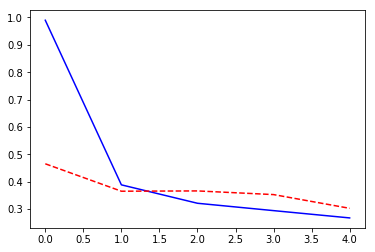

In [8]:
plt.plot(history.history['loss'], 'b-')
plt.plot(history.history['val_loss'], 'r--')

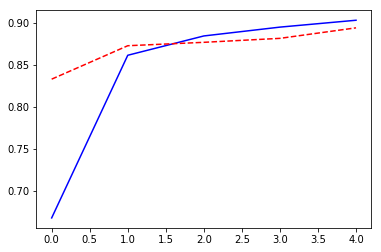

In [9]:
plt.plot(history.history['accuracy'], 'b-')
plt.plot(history.history['val_accuracy'], 'r--')

In [10]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('테스트 정확도:', test_acc)

313/313 - 2s - loss: 0.3139 - accuracy: 0.8923
테스트 정확도: 0.892300009727478


In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [12]:
randIdx = np.random.randint(0, 1000)

images = test_images[randIdx:randIdx+25]
predictions = np.argmax(model.predict(images), axis=1)
print(predictions)

[6 5 2 1 2 1 3 0 9 1 0 9 3 6 7 9 9 4 4 7 1 2 3 6 3]


In [13]:
def plot_images(images, labels, images_per_row=5):
 n_images = len(images)
 n_rows = (n_images-1) // images_per_row + 1
 fig, ax = plt.subplots(n_rows, images_per_row,
                        figsize = (images_per_row * 2, n_rows * 2))
 for i in range(n_rows):
     for j in range(images_per_row):
         if i*images_per_row + j >= n_images: break
         img_idx = i*images_per_row + j
         a_image = images[img_idx].reshape(28,28)
         if n_rows>1: axis = ax[i, j]
         else: axis = ax[j]
         axis.get_xaxis().set_visible(False)
         axis.get_yaxis().set_visible(False)
         label = class_names[labels[img_idx]]
         axis.set_title(label)
         axis.imshow(a_image, cmap='gray', interpolation='nearest')

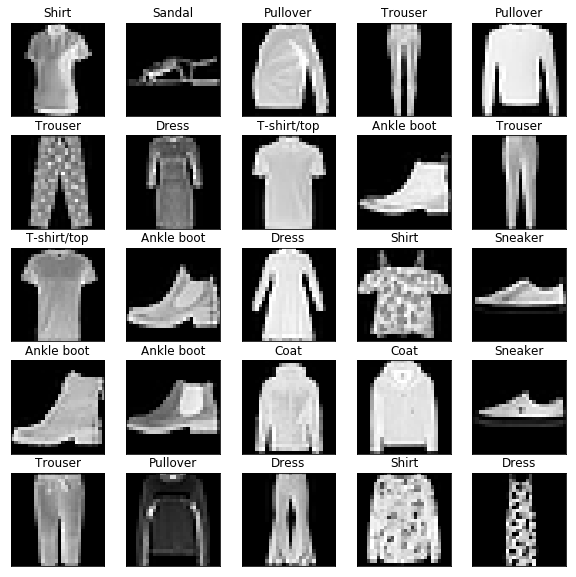

In [14]:
plot_images(images, predictions, images_per_row = 5)

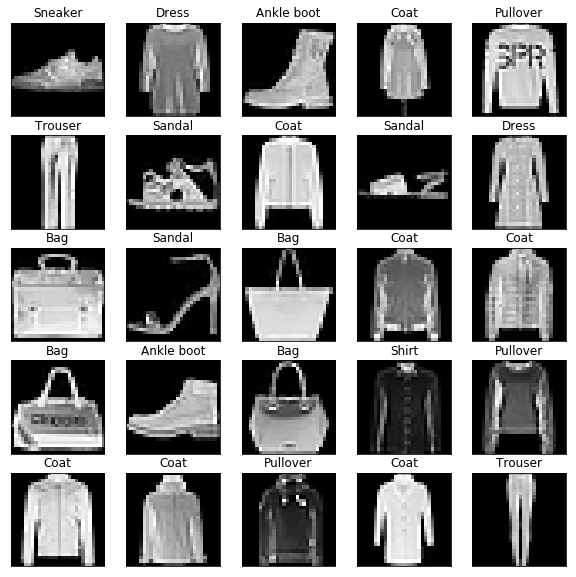

In [15]:
randIdx = np.random.randint(0, 1000)

images = test_images[randIdx:randIdx+25]
predictions = np.argmax(model.predict(images), axis=1)
plot_images(images, predictions, images_per_row = 5)

#### SavedModel로 전체 모델을 저장합니다

In [17]:
model_dir = 'my_model'
model.save(model_dir)

INFO:tensorflow:Assets written to: my_model/assets


## 2. What batch size(s) am I running inference at?

We will use a batch size of 32 for all models:

In [18]:
BATCH_SIZE = 32

## 3. What precision am I running inference at?

In [19]:
PRECISION = "FP32"

## 4. What TensorRT tool or integration am I using to convert my model?

We will be using TF-TRT through the ModelOptimizer example wrapper used in this guide:

In [20]:
from helper import ModelOptimizer
print("Starting", "F_MNIST", model_dir)
model_opt = ModelOptimizer(model_dir)

#save TensorRT engin at my_model_FP32 folder
opt_trt = model_opt.convert(model_dir+'_'+PRECISION, precision=PRECISION)

opt_model = opt_trt
print("Finished!\n")

Starting F_MNIST my_model
INFO:tensorflow:Linked TensorRT version: (8, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 1)
INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: my_model_FP32/assets
Finished!



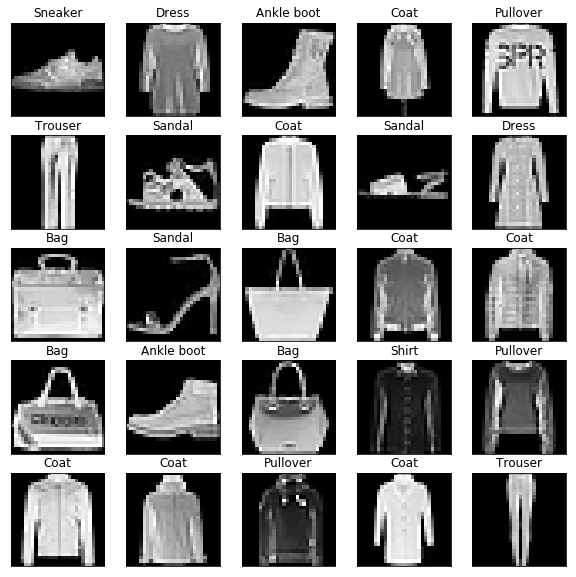

In [21]:
andIdx = np.random.randint(0, 1000)

images = test_images[randIdx:randIdx + BATCH_SIZE]
predictions = np.argmax(opt_model.predict(images), axis=1)
plot_images(images, predictions, images_per_row = 5)

## 5. What TensorRT runtime am I targeting?

We will stay inside our Tensorflow/Python runtime:

In [22]:
opt_model.predict(images)

<tf.Tensor: shape=(25, 10), dtype=float32, numpy=
array([[1.66375191e-16, 1.24819060e-19, 2.93573799e-20, 3.79239143e-20,
        1.21120425e-19, 1.36471208e-04, 1.55146539e-21, 9.99859452e-01,
        3.75703765e-12, 4.05443416e-06],
       [3.63180369e-01, 2.09513055e-05, 1.04607821e-01, 4.06675637e-01,
        5.54472581e-03, 2.55434632e-11, 1.19712956e-01, 9.43208592e-14,
        2.57475418e-04, 1.48677703e-09],
       [1.27993023e-22, 2.49000151e-27, 4.26075295e-32, 1.44146313e-23,
        1.48426233e-32, 6.01134900e-07, 2.21261067e-24, 2.11120982e-06,
        5.62192792e-15, 9.99997258e-01],
       [9.47993340e-06, 5.91348589e-06, 4.20205202e-03, 2.71483295e-04,
        9.86079633e-01, 1.70131281e-21, 9.42773186e-03, 1.80840392e-28,
        3.79131188e-06, 7.82445328e-20],
       [1.71904194e-05, 5.05541626e-13, 9.99963999e-01, 1.22119513e-06,
        2.81875850e-06, 7.29317795e-21, 1.47704268e-05, 1.33069324e-34,
        8.14181611e-09, 4.44529283e-28],
       [1.65406490e-07, 9

### Performance Comparisons:

In [23]:
%%time

model.predict(test_images)

CPU times: user 144 ms, sys: 4 ms, total: 148 ms
Wall time: 156 ms


array([[1.66375191e-16, 1.24818879e-19, 2.93574025e-20, 3.79238239e-20,
        1.21120361e-19, 1.36471164e-04, 1.55146377e-21, 9.99859452e-01,
        3.75704025e-12, 4.05443461e-06],
       [3.63180369e-01, 2.09513000e-05, 1.04607821e-01, 4.06675637e-01,
        5.54472487e-03, 2.55434719e-11, 1.19712956e-01, 9.43208524e-14,
        2.57475331e-04, 1.48677648e-09],
       [1.27992896e-22, 2.49000228e-27, 4.26074443e-32, 1.44146313e-23,
        1.48426042e-32, 6.01134843e-07, 2.21261363e-24, 2.11120937e-06,
        5.62192581e-15, 9.99997258e-01],
       [9.47993612e-06, 5.91348135e-06, 4.20205202e-03, 2.71483266e-04,
        9.86079633e-01, 1.70131301e-21, 9.42773186e-03, 1.80840163e-28,
        3.79131097e-06, 7.82444682e-20],
       [1.71904139e-05, 5.05541464e-13, 9.99963999e-01, 1.22119525e-06,
        2.81875691e-06, 7.29319249e-21, 1.47704268e-05, 1.33069060e-34,
        8.14181345e-09, 4.44528320e-28],
       [1.65406504e-07, 9.99998927e-01, 2.02023931e-14, 1.00923933e-06,
   

In [24]:
%%time

opt_model.predict(test_images)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.6 ms


<tf.Tensor: shape=(25, 10), dtype=float32, numpy=
array([[1.66375191e-16, 1.24819060e-19, 2.93573799e-20, 3.79239143e-20,
        1.21120425e-19, 1.36471208e-04, 1.55146539e-21, 9.99859452e-01,
        3.75703765e-12, 4.05443416e-06],
       [3.63180369e-01, 2.09513055e-05, 1.04607821e-01, 4.06675637e-01,
        5.54472581e-03, 2.55434632e-11, 1.19712956e-01, 9.43208592e-14,
        2.57475418e-04, 1.48677703e-09],
       [1.27993023e-22, 2.49000151e-27, 4.26075295e-32, 1.44146313e-23,
        1.48426233e-32, 6.01134900e-07, 2.21261067e-24, 2.11120982e-06,
        5.62192792e-15, 9.99997258e-01],
       [9.47993340e-06, 5.91348589e-06, 4.20205202e-03, 2.71483295e-04,
        9.86079633e-01, 1.70131281e-21, 9.42773186e-03, 1.80840392e-28,
        3.79131188e-06, 7.82445328e-20],
       [1.71904194e-05, 5.05541626e-13, 9.99963999e-01, 1.22119513e-06,
        2.81875850e-06, 7.29317795e-21, 1.47704268e-05, 1.33069324e-34,
        8.14181611e-09, 4.44529283e-28],
       [1.65406490e-07, 9